## This is for the cart-pole game, it's all about my experiments with the game

In [1]:
import time
import random
import heapq as hp
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline


import tensorflow as tf
from keras import backend as K

config =tf.ConfigProto(
        device_count={'GPU':0}
)
sess=tf.Session(config=config)

K.set_session(sess)

Using TensorFlow backend.


In [2]:
class DQNAgent:
    def __init__(self, state_size, action_size,epsilon_decay = 0.99,gamma=0.95):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = {}
        self.pqt=[]
        self.gamma = 0.95   # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        self.learning_rate = 0.001  # the learning rate
        self.model = self._build_model() # Current model
        self.pev_model=self.model        # Previous model
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        cort_rwd=(reward + self.gamma *
                          np.amax(self.pev_model.predict(next_state)[0]))
        prd_rwd=self.pev_model.predict(next_state)[0][action]
        hp.heappush(self.pqt,-abs(float(cort_rwd - prd_rwd)))
        self.memory[-abs(float(cort_rwd - prd_rwd))]=(state, action, reward, next_state, done)
        
        
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def replay(self, batch_size):
        
        for _ in range(batch_size):
            
            state, action, reward, next_state, done = self.memory[hp.heappop(self.pqt)]
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.pev_model.predict(next_state)[0]))  # q(s,a) = r + max(q(_s,_a)) over _a
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


In [3]:
# After 500 time steps the game automaticly terminates

EPISODES = 1000

def run():
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    time_start=time.time()
    
    agent = DQNAgent(state_size, action_size)
   
    done = False
    batch_size = 32
    vally=0 # Counter for success
    for e in range(EPISODES):
        timestep = 0
        done=False
        state = env.reset() 
        state = np.reshape(state, [1, state_size]) # Encapsulating whole thing into array i.e [[1,12,2,3]]
        while not done:     
            timestep+=1
           # env.render() Run it on your local machine
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            '''
            Problem in Code (1)
            '''
            reward = reward if not done else -10 # Even after completing the task successfully agent got -ve reward ; Logical error
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            '''
            Problem in Code (2)
            '''
            agent.pev_model=agent.model # LoL LoL... Dude it's python
            if done:
                print("episode: {}/{}, score: {}, e: {:.2}"
                      .format(e, EPISODES, timestep, agent.epsilon))
                break
        if timestep>=499 : 
            vally+=1
            print("Time for which pole stand:",timestep,vally)
            if vally==20:
                break
                print("Done after episode:",e-1)
        if len(agent.pqt) > batch_size:
            agent.replay(batch_size)
    end_time=time.time()
    print(end_time-time_start)
    return agent


In [4]:
agent = run()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0/1000, score: 22, e: 1.0
episode: 1/1000, score: 26, e: 1.0
episode: 2/1000, score: 11, e: 0.99
episode: 3/1000, score: 31, e: 0.99
episode: 4/1000, score: 14, e: 0.98
episode: 5/1000, score: 24, e: 0.97
episode: 6/1000, score: 53, e: 0.97
episode: 7/1000, score: 16, e: 0.96
episode: 8/1000, score: 32, e: 0.95
episode: 9/1000, score: 9, e: 0.94
episode: 10/1000, score: 16, e: 0.93
episode: 11/1000, score: 13, e: 0.93
episode: 12/1000, score: 19, e: 0.92
episode: 13/1000, score: 14, e: 0.92
episode: 14/1000, score: 23, e: 0.91
episode: 15/1000, score: 11, e: 0.9
episode: 16/1000, score: 14, e: 0.9
episode: 17/1000, score: 23, e: 0.9
episode: 18/1000, score: 21, e: 0.9
episode: 19/1000, score: 14, e: 0.89
episode: 20/1000, score: 22, e: 0.89
episode: 21/1000, score: 24, e: 0.88
episode: 22/1000, score: 16, e: 0.87
episode: 23/1000, score: 39, e: 0.87
episode: 24/1000, score: 15, e

episode: 216/1000, score: 57, e: 0.14
episode: 217/1000, score: 111, e: 0.14
episode: 218/1000, score: 53, e: 0.14
episode: 219/1000, score: 97, e: 0.14
episode: 220/1000, score: 182, e: 0.13
episode: 221/1000, score: 110, e: 0.13
episode: 222/1000, score: 234, e: 0.13
episode: 223/1000, score: 77, e: 0.13
episode: 224/1000, score: 124, e: 0.13
episode: 225/1000, score: 351, e: 0.13
episode: 226/1000, score: 132, e: 0.13
episode: 227/1000, score: 68, e: 0.12
episode: 228/1000, score: 106, e: 0.12
episode: 229/1000, score: 130, e: 0.12
episode: 230/1000, score: 212, e: 0.12
episode: 231/1000, score: 179, e: 0.12
episode: 232/1000, score: 175, e: 0.12
episode: 233/1000, score: 127, e: 0.12
episode: 234/1000, score: 139, e: 0.12
episode: 235/1000, score: 88, e: 0.12
episode: 236/1000, score: 138, e: 0.11
episode: 237/1000, score: 111, e: 0.11
episode: 238/1000, score: 120, e: 0.11
episode: 239/1000, score: 89, e: 0.11
episode: 240/1000, score: 111, e: 0.11
episode: 241/1000, score: 99, e:

episode: 420/1000, score: 179, e: 0.018
episode: 421/1000, score: 500, e: 0.018
Time for which pole stand: 500 5
episode: 422/1000, score: 307, e: 0.018
episode: 423/1000, score: 175, e: 0.017
episode: 424/1000, score: 277, e: 0.017
episode: 425/1000, score: 500, e: 0.017
Time for which pole stand: 500 6
episode: 426/1000, score: 500, e: 0.017
Time for which pole stand: 500 7
episode: 427/1000, score: 500, e: 0.017
Time for which pole stand: 500 8
episode: 428/1000, score: 10, e: 0.017
episode: 429/1000, score: 119, e: 0.016
episode: 430/1000, score: 266, e: 0.016
episode: 431/1000, score: 183, e: 0.016
episode: 432/1000, score: 170, e: 0.016
episode: 433/1000, score: 179, e: 0.016
episode: 434/1000, score: 224, e: 0.016
episode: 435/1000, score: 316, e: 0.015
episode: 436/1000, score: 207, e: 0.015
episode: 437/1000, score: 152, e: 0.015
episode: 438/1000, score: 500, e: 0.015
Time for which pole stand: 500 9
episode: 439/1000, score: 10, e: 0.015
episode: 440/1000, score: 150, e: 0.0

episode: 612/1000, score: 215, e: 0.0099
episode: 613/1000, score: 202, e: 0.0099
episode: 614/1000, score: 317, e: 0.0099
episode: 615/1000, score: 235, e: 0.0099
episode: 616/1000, score: 303, e: 0.0099
episode: 617/1000, score: 373, e: 0.0099
episode: 618/1000, score: 193, e: 0.0099
episode: 619/1000, score: 500, e: 0.0099
Time for which pole stand: 500 20
94.32083249092102


In [5]:
def policy_evaluation(env,agent):
    avg=0
    lst=[]
    for i in range(100):
        #env.seed(i)
        state=env.reset()
        state=np.reshape(state,[1,agent.state_size])
        action=np.argmax(agent.model.predict(state)[0])
        nxt_state, reward, done, info = env.step(action)
        net_r=0
        while not done:
            net_r+=reward
            state=nxt_state
            state=np.reshape(state, [1,agent.state_size])
            action=np.argmax(agent.model.predict(state)[0])
            nxt_state, reward, done, info = env.step(action)
            #print(nxt_state, reward, done)
        avg+=net_r
        print("Reward for {} episode: {}".format(i,net_r))
        lst.append(net_r)
    print("Avg reward: ",avg/(i+1) )
    print(np.var(lst))
    env.close()

In [6]:
env = gym.make('CartPole-v1')
policy_evaluation(env,agent)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Reward for 0 episode: 475.0
Reward for 1 episode: 295.0
Reward for 2 episode: 305.0
Reward for 3 episode: 499.0
Reward for 4 episode: 334.0
Reward for 5 episode: 271.0
Reward for 6 episode: 324.0
Reward for 7 episode: 263.0
Reward for 8 episode: 297.0
Reward for 9 episode: 301.0
Reward for 10 episode: 298.0
Reward for 11 episode: 309.0
Reward for 12 episode: 499.0
Reward for 13 episode: 320.0
Reward for 14 episode: 315.0
Reward for 15 episode: 299.0
Reward for 16 episode: 338.0
Reward for 17 episode: 308.0
Reward for 18 episode: 242.0
Reward for 19 episode: 296.0
Reward for 20 episode: 499.0
Reward for 21 episode: 365.0
Reward for 22 episode: 307.0
Reward for 23 episode: 304.0
Reward for 24 episode: 370.0
Reward for 25 episode: 259.0
Reward for 26 episode: 315.0
Reward for 27 episode: 299.0
Reward for 28 episode: 294.0
Reward for 29 episode: 276.0
Reward for 30 episode: 499.0
Reward for 3

## Let's begin the experiment

In [7]:


def do_it(agent):
    env.reset()
    time_start=time.time()
    
    
    # agent.load("./save/cartpole-dqn.h5")
    done = False
    batch_size = 32
    vally=[]   # List of episode in which agent complete sucess.
    for e in range(EPISODES):

        done=False
        state = env.reset()  
        state = np.reshape(state, [1, state_size]) # Encapsulating whole thing into and array i.e [[1,12,2,3]]
        for t in range(500):    
            
          #  env.render() 
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.pev_model=agent.model
            if done:
               # print("episode: {}/{}, score: {}, e: {:.2}"
                #      .format(e, EPISODES, t, agent.epsilon))
                break
        if t>=499 : 
            vally.append(e-1)
            #print("Time for which pole stand:",t,vally)
            if len(vally)==10:
                break
                
        if len(agent.pqt) > batch_size:
            agent.replay(batch_size)
    end_time=time.time()
    
    
    #Time to test agent
    
    avg=0
    
    for i in range(100):
        #env.seed(i)
        state=env.reset()
        state=np.reshape(state,[1,agent.state_size])
        action=np.argmax(agent.model.predict(state)[0])
        nxt_state, reward, done, info = env.step(action)
        net_r=0
        while not done:
            net_r+=reward
            state=nxt_state
            state=np.reshape(state, [1,agent.state_size])
            action=np.argmax(agent.model.predict(state)[0])
            nxt_state, reward, done, info = env.step(action)
            #print(nxt_state, reward, done)
        avg+=net_r
        #print("Reward for {} episode: {}".format(i,net_r))
    
    agent.memory.clear()
    agent.pqt.clear()
    
    return([end_time-time_start, vally, avg/(i+1), agent])
        # if e % 10 == 0:
#     agent.save("./save/cartpole-dqn.h5")

In [8]:
#Set some hyperparameters gamma, epsilon_decay
gammaLst=[0.8,0.85,0.9,0.95,1]
epsilon_decayLst=[0.5,0.7,0.8,0.9,0.95,0.98,0.985,0.99,0.995]

## Make agents

In [9]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent_hyp=[]
for i in range(len(gammaLst)):
    agent_gamma=[]
    for j in range(len(epsilon_decayLst)):
        final=[]
        for po in range(3):
            final.append(DQNAgent(state_size, action_size,epsilon_decayLst[j],gammaLst[i]))
        agent_gamma.append(final)
    agent_hyp.append(agent_gamma)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## Test all 135 agents

In [10]:
agent_hyp_perf=[]
for i in range(len(gammaLst)):
    agent_gamma_perf=[]
    for j in range(len(epsilon_decayLst)):
        finl_perf=[]
        for po in range(3):
            finl_perf.append(do_it(agent_hyp[i][j][po]))
        agent_gamma_perf.append([[epsilon_decayLst[j],gammaLst[i]],finl_perf])
    agent_hyp_perf.append(agent_gamma_perf)
    print("Done for gamma : ",gammaLst[i])


Done for gamma :  0.8
Done for gamma :  0.85
Done for gamma :  0.9
Done for gamma :  0.95
Done for gamma :  1


## Analysis

In [11]:
agent_hyp_perf

[[[[0.5, 0.8],
   [[97.44294261932373,
     [189, 195, 199, 201, 203, 205, 206, 208, 213, 214],
     493.91,
    [402.89475750923157,
     [356, 439, 543, 544, 567, 578, 614, 627, 628, 636],
     429.29,
    [291.524729013443,
     [419, 425, 427, 443, 510, 520, 522, 526, 530, 536],
     307.58,
  [[0.7, 0.8],
   [[128.92832016944885,
     [239, 255, 257, 258, 259, 260, 262, 266, 267, 268],
     499.0,
    [292.23563265800476,
     [371, 375, 444, 446, 448, 483, 487, 492, 503, 506],
     387.0,
    [195.63597583770752,
     [191, 203, 204, 206, 236, 237, 239, 313, 319, 321],
     471.04,
  [[0.8, 0.8],
   [[717.0855946540833, [], 128.5, <__main__.DQNAgent at 0x7f834c663978>],
    [269.9499087333679,
     [321, 375, 407, 436, 441, 444, 445, 446, 447, 448],
     499.0,
    [251.48885440826416,
     [370, 375, 376, 391, 397, 400, 404, 407, 414, 416],
     387.36,
  [[0.9, 0.8],
   [[298.52013874053955,
     [280, 299, 302, 314, 318, 355, 370, 375, 383, 388],
     494.56,
    [128.63609457

In [37]:
vally_s = [] #List of vally of every agent
Score = []  # List of Average score of every agent
time = []

for i in range(len(gammaLst)):
    for j in range(len(epsilon_decayLst)):
        for k in range(3):
            Score.append(agent_hyp_perf[i][j][1][k][2])
            vally_s.append(agent_hyp_perf[i][j][1][k][1])
            time.append(agent_hyp_perf[i][j][1][k][0])
            while len(vally_s[-1])!=10:         #If the agent can't achive it's goal for 10 time then append 1000 to vally of that agent
                vally_s[-1].append(1000)
                

In [32]:
for i in range(len(gammaLst)):
    for j in range(len(epsilon_decayLst)):
        for k in range(3):
            if len(agent_hyp_perf[i][j][1][k][1]) == 10 :
                print(agent_hyp_perf[i][j][1][k][0])

97.44294261932373
402.89475750923157
291.524729013443
128.92832016944885
292.23563265800476
195.63597583770752
717.0855946540833
269.9499087333679
251.48885440826416
298.52013874053955
128.6360945701599
468.7130343914032
104.5696611404419
675.8986990451813
138.99923729896545
622.2966065406799
385.50066471099854
550.7449831962585
191.17514991760254
124.67822766304016
176.84623432159424
178.81956124305725
196.86180353164673
182.48807430267334
865.9555160999298
270.37765431404114
339.69586205482483
218.62872862815857
443.70321702957153
218.68622541427612
146.80424666404724
178.90969586372375
94.71107816696167
289.8935616016388
331.3942427635193
130.7406930923462
124.64089155197144
379.8803172111511
246.69569063186646
285.0094666481018
736.8443729877472
415.62632846832275
180.88055443763733
210.52255511283875
176.2037432193756
433.4819886684418
925.4184591770172
317.5970711708069
166.44380617141724
264.46527099609375
359.0708358287811
195.03551578521729
180.03059697151184
575.491926908493


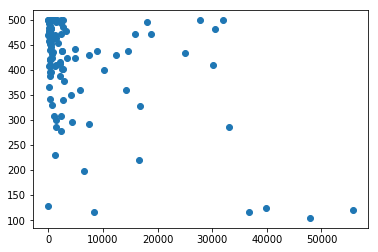

In [35]:
agentVarience = [np.var(vally) for vally in vally_s] # Variance of episode in which agent score perfect 500 score

plt.scatter(x=agentVarience, y=Score)

In [41]:
np.corrcoef(x=agentVarience, y=Score)

array([[ 1.        , -0.51065297],
       [-0.51065297,  1.        ]])

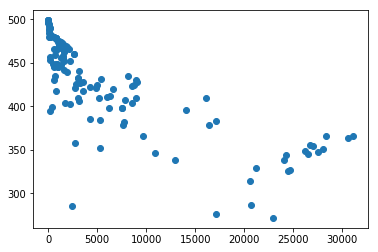

In [36]:
varScore = [] #Variance of Score of agent having same hyperparameters
avgScore = [] # Average of Score of agent having same hyperparameters

for i in range(len(Score)): # len(avgScore) = 135
    varScore.append(np.var(Score[i:i+3]))  
    avgScore.append(np.mean(Score[i:i+3])) 

plt.scatter(x=varScore, y=avgScore)

In [42]:
np.corrcoef(x=varScore, y=avgScore)

array([[ 1.        , -0.78377201],
       [-0.78377201,  1.        ]])

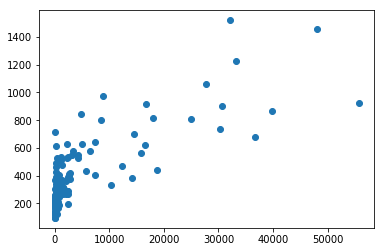

In [39]:
plt.scatter(x=agentVarience, y=time)

In [40]:
np.corrcoef(x=agentVarience, y=time)

array([[1.        , 0.78480415],
       [0.78480415, 1.        ]])

# Observation :
* Most of the time for high Score, agentVarience is less.
* Most of the time for high avgScore, varAvgScore is less.
* The one with the more agentVarience took more time.
* For same hyperparameter agent Score are differnet.

# Conclusion :
* agentVarience should be less for proper convergence.
* varAvgScore should be less for proper convergence.
* The agent is getting a negative reward even after completing the goal, maybe due to this agent is not converging properly.